## **IT3212 - Assignment 2 - Group 25**
**Developers:** *Thomas Haugan, David Spilde, Anders Stubberud and Erlend Løken Sæveraas*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from IPython.display import display, HTML
from sklearn.decomposition import PCA

from skimage import color, data
from skimage.feature import hog
import cv2

import torch
import torchvision
import torchvision.transforms as transforms

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

---
## **Fourier Transform (20 points)**

**Load a grayscale image and apply the 2D Discrete Fourier Transform (DFT) to it. Visualize the original image and its frequency spectrum (magnitude). Submit the images, and explanation**

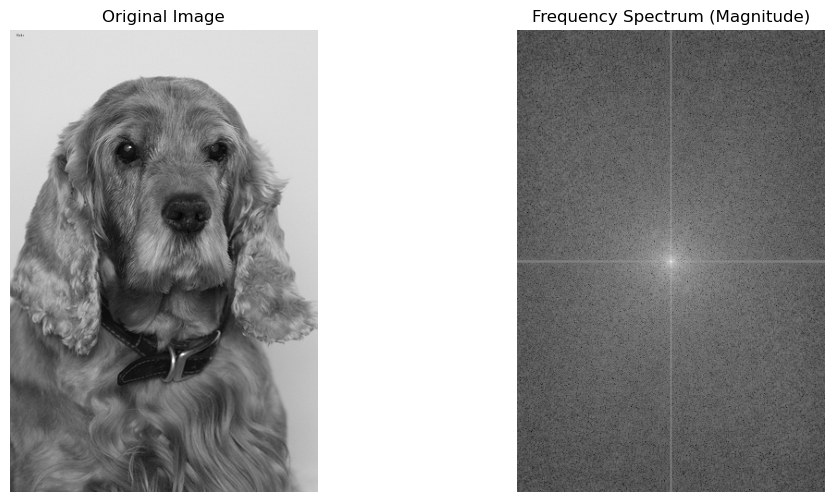

In [8]:
image_path = '../data/oxford-iiit-pet/images/english_cocker_spaniel_13.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply the 2D Discrete Fourier Transform (DFT)
dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

# Plot the original image and the magnitude spectrum
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Magnitude Spectrum (Frequency Spectrum)
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Frequency Spectrum (Magnitude)')
plt.axis('off')
plt.show()

**Explanation**
<br>
The 2D Fourier transform comes in handy for image processing since the representation in the
frequency domain enables several neat techniques, easing processes such as edge detection, texture
recognition, noise reduction, and compression.
Here, the discrete Fourier transform takes as input a greyscale image represented in the spacial
domain, where the values are the intensities of the pixels in the image. The output is the image
represented in the frequency domain, showing the decomposition of constituent frequencies.
Depicted in the center of the frequency spectrum in figure 1 is the direct current component,
often referred to as DC. DC represents the (0, 0) frequency term, which is made up of the sum of
all pixel intensities in the original image, thus representing the average brightness. This average
value is typically fairly large for images. Furthermore, the background of this image is practically
homogeneous, further contributing with low frequencies. The strong presence of low frequencies
result in a bright spot at and around the center of the frequency spectrum. Contrary, the high
frequencies represent rapid changes in pixel intensities, and are located towards the boundaries of
the frequency spectrum. In this image, high frequencies are necessary to reflect the sharp change
in pixel intensities occurring at areas such as the border between the light fur and the dark collar.
The high frequencies are visible as the medium-bright horizontal and vertical lines

**Implement a low-pass filter in the frequency domain to remove high-frequency noise from an image. Compare the filtered image with the original image. Submit images, and analysis of the results**

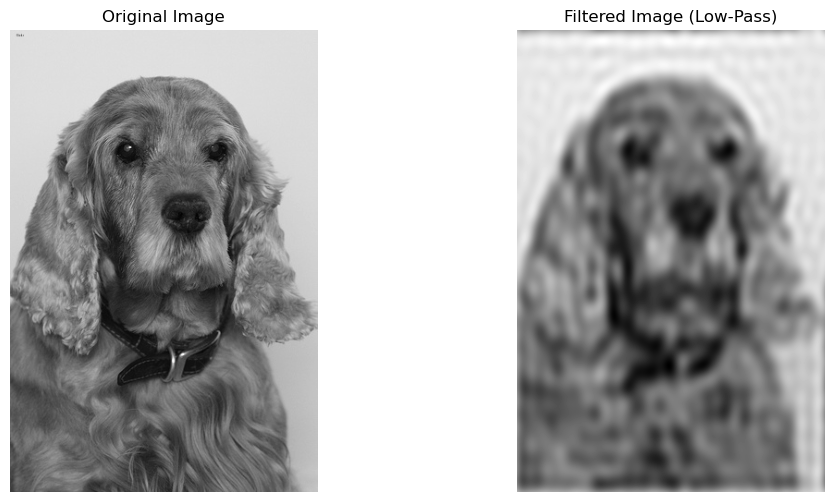

In [13]:
# Create a low-pass filter mask
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2  # Center of the image
radius = 20  # Adjust radius as needed for filtering
mask = np.zeros((rows, cols, 2), np.uint8)
cv2.circle(mask, (ccol, crow), radius, (1, 1), thickness=-1)  # Create a circular mask

# Apply the mask to the DFT
filtered_dft_shift = dft_shift * mask

# Inverse DFT to get the filtered image
filtered_dft_shift_ishift = np.fft.ifftshift(filtered_dft_shift)
filtered_image = cv2.idft(filtered_dft_shift_ishift)
filtered_image_magnitude = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Plot the original image and the filtered image
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Filtered Image
plt.subplot(1, 2, 2)
plt.imshow(filtered_image_magnitude, cmap='gray')
plt.title('Filtered Image (Low-Pass)')
plt.axis('off')
plt.show()

**Analysis of results**
<br>
Low-pass filters are used to remove noise in the image, which can be defined as: ‘random variation
of brightness or color information in the images captured’. Thus, for grayscale images, noise
can be viewed as random variation in pixel intensity. Intuitively, it is desirable to reduce the noise.
Pixels with intensities deviating significantly from nearby pixels (such as is the result with random
variation) will be represented by a high frequency component, since high frequencies signify rapid
changes in pixel intensities. Thus, to eliminate noise, low-pass filters eliminate frequencies above
a certain threshold in the frequency spectrum.

Comparing the original image with it’s low-pass filter counterpart in figure 2, it’s apparent that
the image is blurred and smoothed out. Finer details such as edges and textures are no longer
as prominent. This is a by-product of the low-pass filter; sharp changes in pixel intensities are
represented by high frequencies whether they originate from noise or not, and is thus at risk of
being removed by the filter

**Implement a high-pass filter to enhance the edges in an image. Visualize the filtered image and discuss the effects observed. Submit images, and explanation**


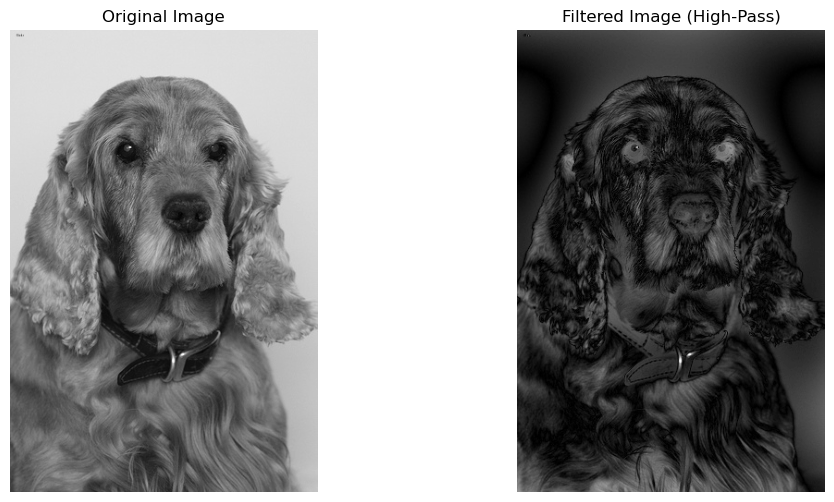

In [14]:
dft_result = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shifted = np.fft.fftshift(dft_result)  # Shift the zero frequency component to the center

# Create a mask for high-pass filtering
rows, cols = image.shape
center_row, center_col = rows // 2, cols // 2  # center

# Create a circular mask for low frequencies
radius = 2.5  # Adjust this value for desired cut-off frequency
x, y = np.ogrid[:rows, :cols]
mask = (x - center_row) ** 2 + (y - center_col) ** 2 <= radius ** 2
dft_shifted[mask] = 0  # Set the low frequencies to zero for high-pass filtering

# Apply the inverse shift before the inverse DFT
dft_shifted = np.fft.ifftshift(dft_shifted)

# Apply the inverse DFT to get the high-pass filtered image
high_pass_filtered_image = cv2.idft(dft_shifted)
high_pass_filtered_image = cv2.magnitude(high_pass_filtered_image[:, :, 0], high_pass_filtered_image[:, :, 1])

# Normalize the filtered image for display
high_pass_filtered_image = cv2.normalize(high_pass_filtered_image, None, 0, 255, cv2.NORM_MINMAX)
high_pass_filtered_image = np.uint8(high_pass_filtered_image)

# Plot the original image and the high-pass filtered image
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# High-Pass Filtered Image
plt.subplot(1, 2, 2)
plt.imshow(high_pass_filtered_image, cmap='gray')
plt.title('Filtered Image (High-Pass)')
plt.axis('off')
plt.show()

**Discussion of observed effects**
<br>
Contrary to low-pass filters, high-pass filters keeps frequencies above a certain threshold, while
reducing the strength of frequencies below it. Consequently, as higher frequencies to a greater
extent dominate the frequency spectrum, finer details such as edges and textures will be more
prominent. Therefore, this technique serves useful for applications such as edge detection and
texture recognition.
Visualizing the high-pass filtered image in figure 3 illustrates the effects; certain finer details, such
as the dog’s pupils, are far more pronounced than in the original image. Furthermore, frequencies
constituted by homogeneous areas from the original image, such as the lightly-colored background,
have clearly diminished in strength, appearing much darker

**Implement an image compression technique using Fourier Transform by selectively keeping only a certain percentage of the Fourier coefficients. Evaluate the quality of the reconstructed image as you vary the percentage of coefficients used. Submit the images, and your observations on image quality and compression ratio**

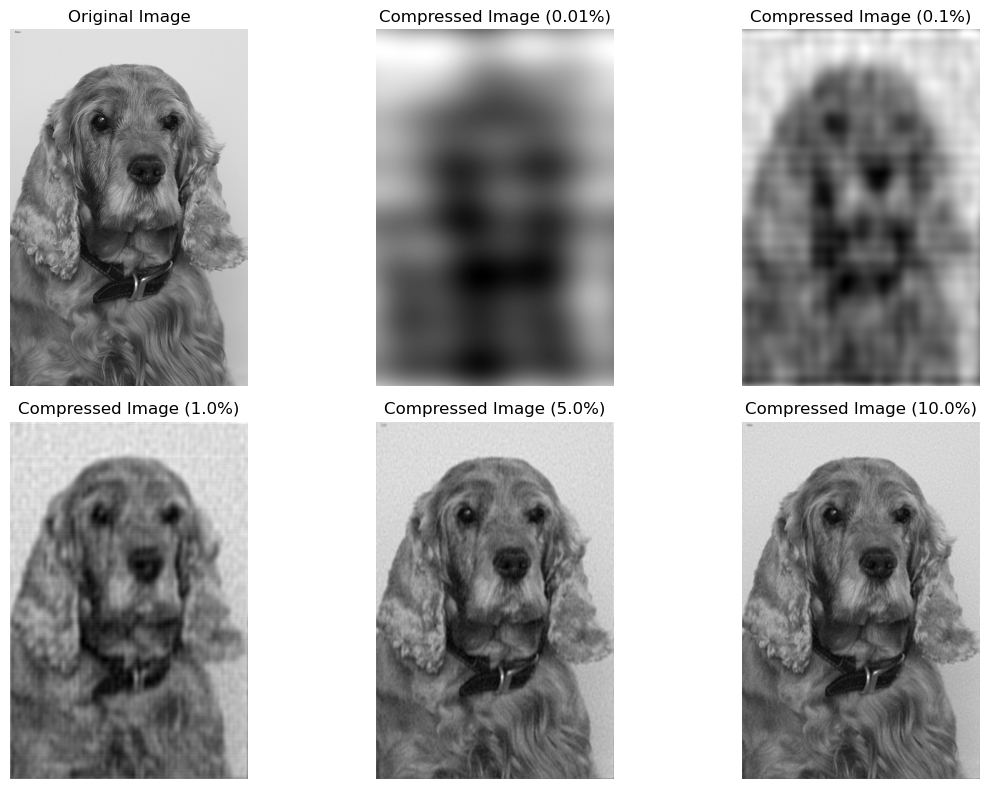

In [15]:
def compress_image_with_dft(image, keep_percentage):
    # Apply the 2D Discrete Fourier Transform (DFT)
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

    # Get the magnitude and phase of the Fourier coefficients
    magnitude_spectrum = np.abs(dft_shift)
    phase_spectrum = np.angle(dft_shift)

    # Flatten the magnitude and find the threshold for keeping the largest coefficients
    flattened_magnitude = magnitude_spectrum.flatten()
    sorted_magnitude = np.sort(flattened_magnitude)
    threshold = sorted_magnitude[int((1 - keep_percentage) * len(sorted_magnitude))]

    # Create a mask to zero out coefficients below the threshold
    magnitude_mask = magnitude_spectrum >= threshold

    # Apply the mask to keep only the selected percentage of coefficients
    compressed_dft_shift = dft_shift * magnitude_mask

    # Reconstruct the image from the compressed DFT
    compressed_dft = np.fft.ifftshift(compressed_dft_shift)  # Inverse shift
    compressed_image = cv2.idft(compressed_dft)
    compressed_image = cv2.magnitude(compressed_image[:, :, 0], compressed_image[:, :, 1])  # Get the magnitude

    return compressed_image

# Load the image
image_path = '../data/oxford-iiit-pet/images/english_cocker_spaniel_13.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Compress the image with different percentages of Fourier coefficients
percentages = [0.0001, 0.001, 0.01, 0.05, 0.1]  # 10%, 30%, 50%
compressed_images = [compress_image_with_dft(image, p) for p in percentages]

# Plot the original image and the compressed images
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Compressed Images
for i, (p, comp_img) in enumerate(zip(percentages, compressed_images), start=2):
    plt.subplot(2, 3, i)
    plt.imshow(comp_img, cmap='gray')
    plt.title(f'Compressed Image ({p*100}%)')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Observations on image quality and compression ratio**
<br>
Digital images may contain redundant data in the form of highly correlated pixels not noticeable
for the human eye. Since these finer details have a rather small impact on the overall appear-
ance of the image, they can be discarded while preserving acceptable visual quality in the image.
Transforming the image to the frequency domain and keeping only a set percentage of the most
dominating frequency coefficients in terms of magnitude can thus compress the image.
Figure 4 depicts the original image along with 5 images with varying percentage of retained coef-
ficients. Keeping only 0.01%-0.1% of the coefficients shows a significant decrease in visual quality,
which can be accredited to the lack of details such as edges and textures which were represented
by high frequencies of low magnitude. Retaining 1% has evidently preserved some mid- and higher
frequency components, as there now is some granularity visible in the image. At 5% or more, The
frequency coefficients responsible for details visible to the human eye are presumably preserved, as
there is no distinguishable difference from the original image. This demonstrates that a significant
portion of the image’s data can be discarded without noticeable effect on image quality.

---
## **PCA (25 points)**

---
## **HOG Features (12 points)**

**(1) Write a Python script to compute the HOG features of a given image using a library such as OpenCV or scikit-image<br>
(2) Apply your implementation to at least three different images, including both simple and complex scenes<br>
(3) Visualize the original image, the gradient image, and the HOG feature image**

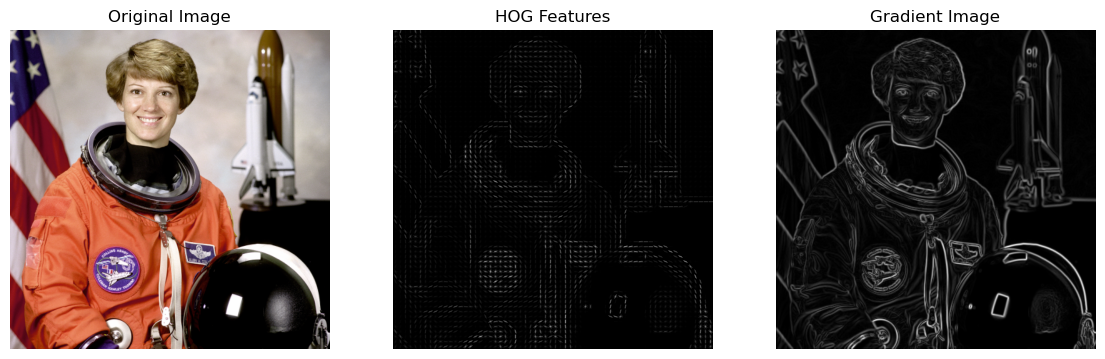

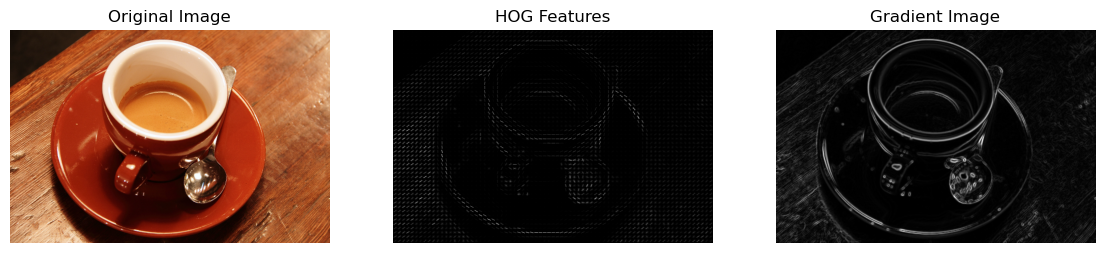

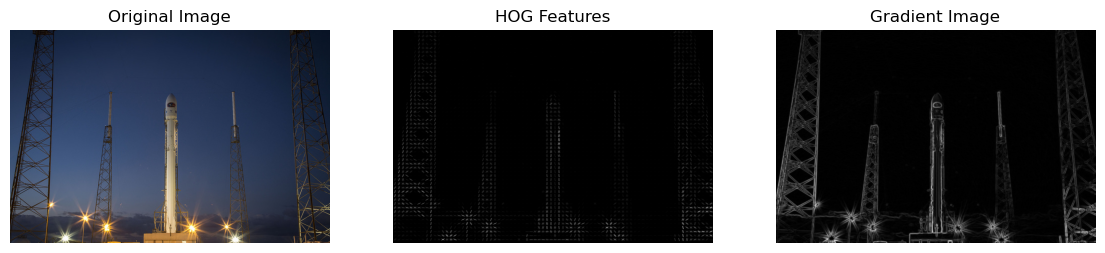

In [3]:
def compute_hog_features(original_image):
    gray_image = color.rgb2gray(original_image)

    # Compute HOG features
    return hog (
        gray_image, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(1, 1), 
        visualize=True, 
    )

def compute_gradient_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute gradients
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
    # Combine gradients
    gradient_image = cv2.magnitude(grad_x, grad_y)
    
    return gradient_image

images = [data.astronaut(), data.coffee(), data.rocket()]

for img in images:
    _, hog_image = compute_hog_features(img)
    gradients = compute_gradient_image(img)
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(14, 10))

    # Plot original image
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot HOG image
    axes[1].imshow(hog_image, cmap='grey')
    axes[1].set_title('HOG Features')
    axes[1].axis('off')

    # Plot HOG features
    axes[2].imshow(gradients, cmap='grey')
    axes[2].set_title('Gradient Image')
    axes[2].axis('off')
    plt.show()

**Compare the HOG features extracted from different images. Discuss the impact of varying parameters like cell size, block size, and the number of bins on the resulting HOG descriptors**

**1. Cell size** is the dimensions of the pixel regions over which gradient histograms are computed. Smaller cell size results in more sensitive features capturing finer details and local variations in the image, while larger cell size focuses more on prominent features. Larger cell size might miss subtle gradients and therefore miss important spatial information.

**2. Block Size** Smaller block size allows for finer normalization of features and helps emphasizing local changes. Larger block size provides more global normalization across features and can improve robustness against illumination changes. If block is too large this may blur important local features and reduce the ability to distinguish between classes.

**3. Number of Bins** Many bins increases the of the orientation information allowing more precise feature extraction. Fewer bins reduces model complexity and the risk of overfitting and leads to a loss of fine directional information, as it might not accurately capture edge orientation, leading to reduced discriminative ability.

---
## **Local Binary Patterns (LBP) (13 points)**

**Write a Python function to compute the LBP of a given grayscale image. Use the basic 8-neighbor LBP method. Compute the histograms on minimum three different images**

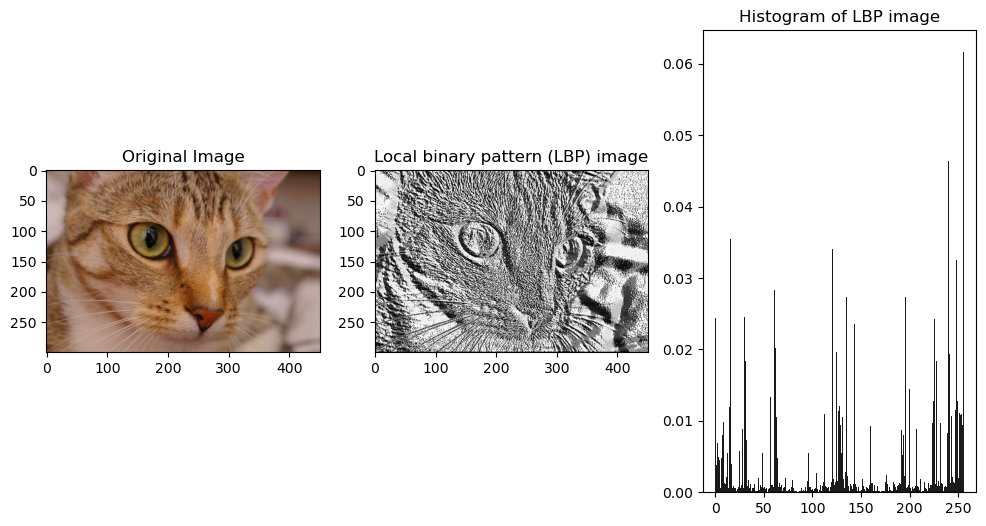

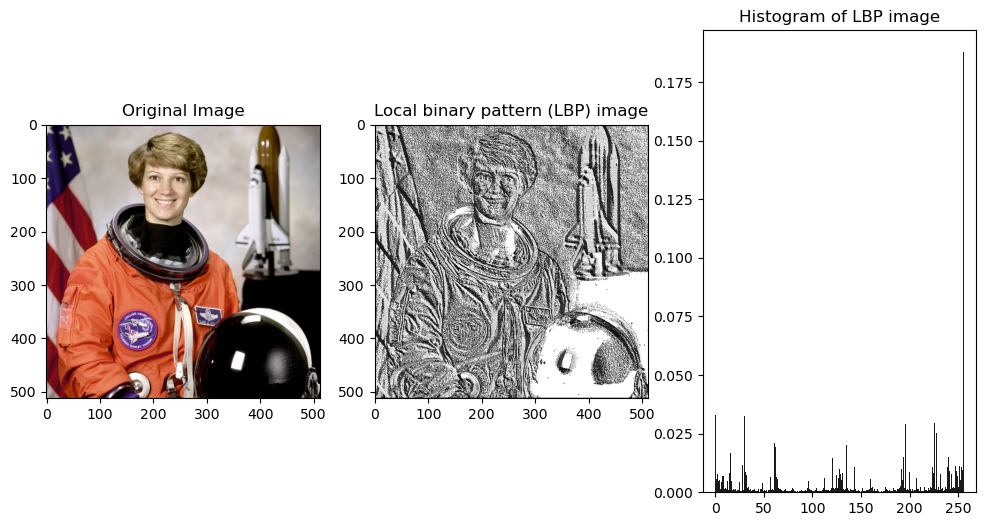

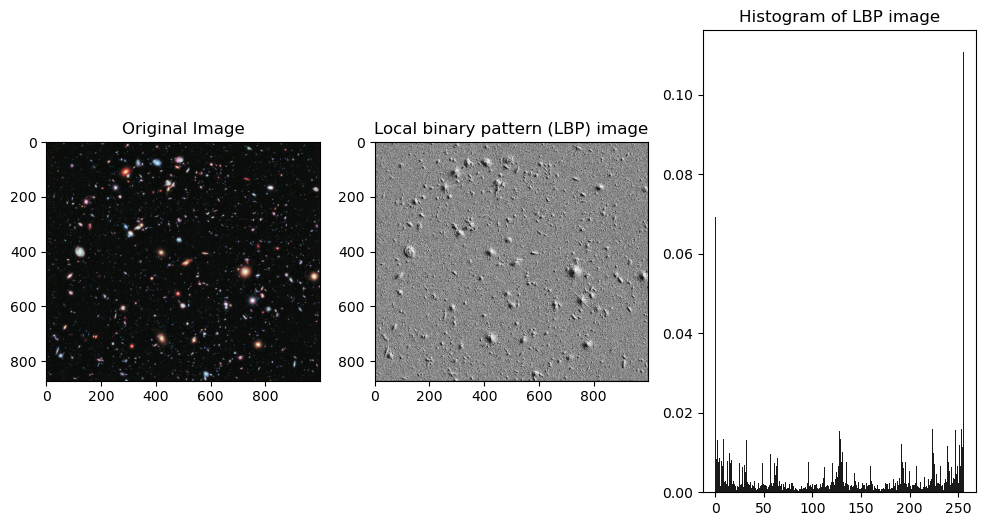

In [4]:
# local Binary Patterns
def get_pixel(img, center, x, y):
    new_value = 0
      
    try:
        # If local neighbourhood pixel value is greater than or equal
        # to center pixel values then set it to 1
        if img[x][y] >= center:
            new_value = 1      
    except:
        # Exception is required when neighbourhood value of a center
        # pixel value is null i.e. values present at boundaries.
        pass
      
    return new_value
   
# Function for calculating LBP
def lbp_calculated_pixel(img, x, y):
   
    center = img[x][y]
    val_ar = []
    val = 0.0

    # top_left
    val_ar.append(get_pixel(img, center, x-1, y-1))
      
    # top
    val_ar.append(get_pixel(img, center, x-1, y))
      
    # top_right
    val_ar.append(get_pixel(img, center, x-1, y + 1))
      
    # right
    val_ar.append(get_pixel(img, center, x, y + 1))
      
    # bottom_right
    val_ar.append(get_pixel(img, center, x + 1, y + 1))
      
    # bottom
    val_ar.append(get_pixel(img, center, x + 1, y))
      
    # bottom_left
    val_ar.append(get_pixel(img, center, x + 1, y-1))
      
    # left
    val_ar.append(get_pixel(img, center, x, y-1))
       
    # Convert binary values to decimal
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
   
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
          
    return val

def histo_gram(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return hist(
        lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

images = [data.chelsea(), data.astronaut(), data.hubble_deep_field()]

for img in images:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img_gray.shape
    lbp_img = np.zeros((height, width), np.uint8)
    
    for i in range(0, height):
        for j in range(0, width):
            lbp_img[i, j] = lbp_calculated_pixel(img_gray, i, j)

    hist, bin = np.histogram(lbp_img.ravel(), 256, [0,255])
    #histo = histo_gram(lbp_img)
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    
    # Plot original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    #axes[0].axis('off')

    # Plot LBP image
    axes[1].imshow(lbp_img, cmap='grey')
    axes[1].set_title('Local binary pattern (LBP) image')
    #axes[1].axis('off')

    # Plot histogram
    n_bins = 256
    axes[2].hist(
        lbp_img.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.1')
    axes[2].set_title('Histogram of LBP image')
    #axes[2].axis('off')

    plt.show()

**Explain what the histogram represents in terms of the texture features of the image**
<br>
In general terms the histogram of local binary pattern images (LBP) captures the frequency of occurence of different patterns and textures in the image. Textures with distinct patterns will result in histograms with prominent peaks at specific LBP values, while homogeneous textures result in more uniform histograms. It can highlight features like spots, line endings, edges and corners. Thus by comparing histograms from different images we can assess similarities and differences in texture, which is useful in say face recognition and texture classification. The local binary pattern algorithm is usually a pre-processing stage where its output becomes the input data for some machine learning model, such as support vector machines (SVM). Using the basic LBP method of 8 surrounding pixels we have a total of $2^8=256$ possible combinations of LBP codes, thus a 256-bin histogram is sufficient to assess the final LBP-codes feature vector.

**Compare and discuss differences in histograms and what they tell you about the textures of he three LBP images**
<br>
The LBP histograms of the astronaut and universe images are somewhat different from the cat image. The cat image shows a LBP histogram with many distinct spikes, while the two others images have more uniform distrubutions. This cat photo has many close up and distinct visual features with its striped fur, which may explain the spiky histogram. The female astronaut image contains many large areas of monotone colors black, white and orange, and may explain why the corresponding histogram has fewer and smaller spikes. We see similar uniform LBP histogram for the Hubble deep field image which is fairly even in color/intensity as it is largely black background, the LBP code around zero as the most prominent peak, zero means the darkest shade of gray (black) and represent featureless content of the image. It should be noted that experimenting with different number of bins the resulting histograms will change characteristics accordingly. 

---
## **Implement a blob detection algorithm (15 points)**

In [5]:
# TODO

---
## **Implement a contour detection algorithm (15 points)**

In [7]:
# TODO